# Creating a motif finder


In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
from itertools import combinations, permutations
from collections import defaultdict
import matplotlib.pyplot as plt

# only allow 100 rows to display pandas
pd.set_option('display.max_rows', 100)

In [164]:
syn_table = pd.read_csv('/Users/rweberla/Downloads/connections.csv')
syn_table

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [165]:
# Find all unique cell ids in both the pre and post columns
cellids =  np.unique(syn_table[["pre_root_id", "post_root_id"]])
print(len(cellids))

134181


In [166]:
syn_table = syn_table[syn_table['syn_count'] >= 15]
syn_table

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
5,720575940619895125,720575940618561403,AL_L,31,ACH
6,720575940659399809,720575940604569824,AVLP_R,158,ACH
...,...,...,...,...,...
3869650,720575940617281141,720575940626299082,ME_R,16,ACH
3869652,720575940632107567,720575940616537461,LO_L,16,ACH
3869710,720575940611708565,720575940631708921,ME_R,15,ACH
3869757,720575940618808491,720575940615758041,ME_R,33,ACH


In [167]:
# Find 720575940628360506 and oviEN in both pre_root_id or post_root_id columns
syn_table_limit_test = syn_table[["pre_root_id", "pre_root_id"]]
syn_table_limit_test 

,pre_root_id,pre_root_id
1,720575940605876866,720575940605876866
2,720575940627737365,720575940627737365
3,720575940633587552,720575940633587552
5,720575940619895125,720575940619895125
6,720575940659399809,720575940659399809
...,...,...
3869650,720575940617281141,720575940617281141
3869652,720575940632107567,720575940632107567
3869710,720575940611708565,720575940611708565
3869757,720575940618808491,720575940618808491


## Found this function called succesors in networkx!
This allows you to create a directed graph and find all triads in this reference:
- Snijders, T. (2012). “Transitivity and triads.” University of Oxford. https://web.archive.org/web/20170830032057/http://www.stats.ox.ac.uk/~snijders/Trans_Triads_ha.pdf

Our motif is the "120U". We will probably need to use the HPC to do the whole connectome. 

This method was developed with help from co-pilot. The testing was done with df_test

In [332]:
# Isolated test for exact motif we want
e_test= [(11,21), (21,10), (21,11), (11,10)]
df_test = pd.DataFrame(columns=["s", "t"], data = e_test)
v_test = np.unique(df_test[["s", "t"]])
df_test

,s,t
0,11,21
1,21,10
2,21,11
3,11,10


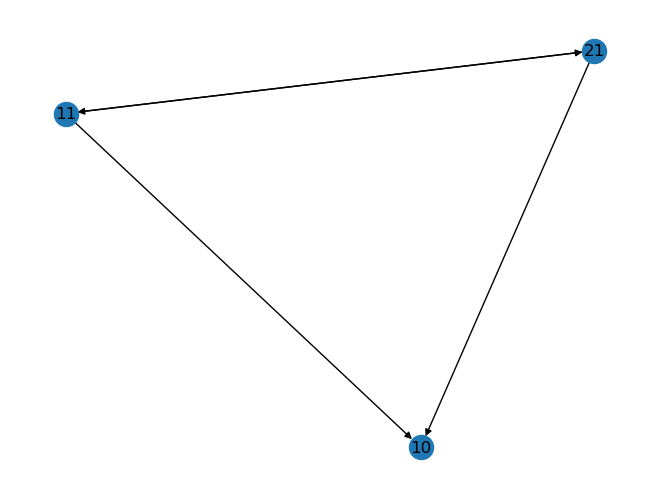

In [333]:
G = nx.DiGraph()
# Add the edges to the graph from dataframe
G.add_edges_from(df_test.values)

# Plot the graph
nx.draw(G, with_labels=True)

In [334]:
num_120U_triads = 0
tri_by_type = defaultdict(list)
unique_triads = set()

print("Starting to count triads")
for i, A in enumerate(G.nodes()):
    # Find all successors of A
    for B in G.successors(A):
        for C in G.successors(A):
            if B != C and G.has_edge(C, A) and G.has_edge(C, B):
                # Sort the nodes to ensure consistency
                triad = tuple(sorted([A, B, C]))
                if triad not in unique_triads:
                    unique_triads.add(triad)
                    # Identify the reciprocal nodes and the third node
                    if G.has_edge(A, B) and G.has_edge(B, A):
                        reciprocal_nodes = (A, B)
                        third_node = C
                    elif G.has_edge(A, C) and G.has_edge(C, A):
                        reciprocal_nodes = (A, C)
                        third_node = B
                    elif G.has_edge(B, C) and G.has_edge(C, B):
                        reciprocal_nodes = (B, C)
                        third_node = A
                    tri_by_type["120U"].append([reciprocal_nodes,third_node])
                    num_120U_triads += 1

Starting to count triads


In [335]:
tri_by_type["120U"]

[[(11, 21), 10]]

In [336]:
num_120U_triads

1

# Testing for descending type finding
1. Import run data
2. import descending data
3. Compare!

In [148]:
# Import txt file, there is also a parenthesis issue (at the beginning and end of each line, need to get rid of them)
df_found = pd.read_csv('/Users/rweberla/Downloads/wholeNet_120U_triads.txt', sep=",", header=None, names=["reciprocal1", "reciprocal2", "nid"])
# Strip the parenthesis from the column values
df_found["reciprocal1"] = df_found["reciprocal1"].str.strip("(")
df_found["nid"] = df_found["nid"].str.strip(")")
df_found

,reciprocal1,reciprocal2,nid
0,81532,88082,30287
1,81532,88082,132028
2,81532,88082,2641
3,81532,88082,33516
4,81532,88082,55868
...,...,...,...
99517,86282,104134,43008
99518,99898,38093,22684
99519,124593,76758,78511
99520,84607,66821,65297


In [149]:
# map edge ids to cell ids
df_found["reciprocal1"] = df_found["reciprocal1"].astype(int)
df_found["nid"] = df_found["nid"].astype(int)
df_found["reciprocal1"] = df_found["reciprocal1"].map(nid2cid)
df_found["reciprocal2"] = df_found["reciprocal2"].map(nid2cid)
df_found["nid"] = df_found["nid"].map(nid2cid)
df_found

,reciprocal1,reciprocal2,nid
0,720575940627737365,720575940628914436,720575940617537570
1,720575940627737365,720575940628914436,720575940648650884
2,720575940627737365,720575940628914436,720575940606056905
3,720575940627737365,720575940628914436,720575940618308825
4,720575940627737365,720575940628914436,720575940622920074
...,...,...,...
99517,720575940628582888,720575940632232418,720575940620608647
99518,720575940631261637,720575940619531072,720575940615324822
99519,720575940640153216,720575940626933706,720575940627209994
99520,720575940628285973,720575940624948553,720575940624654570


In [150]:
# Import descending data
df_desc = pd.read_csv('/Users/rweberla/Downloads/classification.csv')
df_desc

,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
0,720575940640144768,intrinsic,optic,NaN,L1-5,L1,NaN,NaN,right,NaN
1,720575940630759755,intrinsic,central,NaN,NaN,CB1092,NaN,LB3,left,NaN
2,720575940637932009,intrinsic,central,Kenyon_Cell,NaN,NaN,KCg-m,MBp3,left,NaN
3,720575940606131116,intrinsic,optic,NaN,NaN,Tlp4,NaN,NaN,left,NaN
4,720575940633723091,intrinsic,optic,NaN,NaN,Tm4,NaN,NaN,left,NaN
...,...,...,...,...,...,...,...,...,...,...
139250,720575940632239661,afferent,sensory,olfactory,NaN,ORN_VM6l,ORN_VC5,NaN,right,AN
139251,720575940624423312,intrinsic,optic,NaN,NaN,TmY5a,NaN,NaN,right,NaN
139252,720575940625090916,intrinsic,optic,NaN,NaN,NaN,NaN,NaN,left,NaN
139253,720575940631596103,intrinsic,optic,NaN,NaN,T2a,NaN,NaN,left,NaN


In [143]:
df_desc[df_desc['super_class']=='descending']

,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
5,720575940632934751,efferent,descending,NaN,NaN,DNge094,NaN,LB7,right,CV
60,720575940640128720,efferent,descending,NaN,NaN,DNpe015,NaN,PSp2,right,CV
461,720575940610010521,efferent,descending,NaN,NaN,NaN,DNp17,PSp2,right,CV
557,720575940615495867,efferent,descending,NaN,NaN,DNge091,NaN,LB7,right,CV
716,720575940631498563,efferent,descending,NaN,NaN,NaN,DNa08,WEDd1,left,CV
...,...,...,...,...,...,...,...,...,...,...
138269,720575940605041330,efferent,descending,NaN,NaN,NaN,DNp16,PSp2,right,CV
138514,720575940623128269,efferent,descending,NaN,NaN,DNg37,NaN,putative_primary,left,CV
138844,720575940618870881,efferent,descending,NaN,NaN,DNpe009,PS226,PSp2,left,CV
139040,720575940609260494,efferent,descending,NaN,NaN,DNg14,NaN,putative_primary,right,CV


In [151]:
# I want to change the data type of the nid column to int (83823.0 to 83823)
df_desc = df_desc[["root_id", "super_class"]].dropna()
df_desc

,root_id,super_class
0,720575940640144768,optic
1,720575940630759755,central
2,720575940637932009,central
3,720575940606131116,optic
4,720575940633723091,optic
...,...,...
139250,720575940632239661,sensory
139251,720575940624423312,optic
139252,720575940625090916,optic
139253,720575940631596103,optic


In [13]:
type(df_desc['root_id'][0])

numpy.int64

In [152]:
# Combine nid from df_desc onto df_found, if there isn't a match then put "other"
df_found_desc = df_found.merge(df_desc, left_on='nid', right_on='root_id', how='left')
df_found_desc

,reciprocal1,reciprocal2,nid,root_id,super_class
0,720575940627737365,720575940628914436,720575940617537570,720575940617537570,central
1,720575940627737365,720575940628914436,720575940648650884,720575940648650884,central
2,720575940627737365,720575940628914436,720575940606056905,720575940606056905,central
3,720575940627737365,720575940628914436,720575940618308825,720575940618308825,central
4,720575940627737365,720575940628914436,720575940622920074,720575940622920074,central
...,...,...,...,...,...
99517,720575940628582888,720575940632232418,720575940620608647,720575940620608647,optic
99518,720575940631261637,720575940619531072,720575940615324822,720575940615324822,optic
99519,720575940640153216,720575940626933706,720575940627209994,720575940627209994,optic
99520,720575940628285973,720575940624948553,720575940624654570,720575940624654570,optic


In [15]:
# Change root_id to see all numbers, int64
df_found_desc['root_id'] = df_found_desc['root_id'].astype('Int64')

In [153]:
df_found_desc

,reciprocal1,reciprocal2,nid,root_id,super_class
0,720575940627737365,720575940628914436,720575940617537570,720575940617537570,central
1,720575940627737365,720575940628914436,720575940648650884,720575940648650884,central
2,720575940627737365,720575940628914436,720575940606056905,720575940606056905,central
3,720575940627737365,720575940628914436,720575940618308825,720575940618308825,central
4,720575940627737365,720575940628914436,720575940622920074,720575940622920074,central
...,...,...,...,...,...
99517,720575940628582888,720575940632232418,720575940620608647,720575940620608647,optic
99518,720575940631261637,720575940619531072,720575940615324822,720575940615324822,optic
99519,720575940640153216,720575940626933706,720575940627209994,720575940627209994,optic
99520,720575940628285973,720575940624948553,720575940624654570,720575940624654570,optic


Text(0.5, 1.0, 'Number of 120U Triads by Super Class')

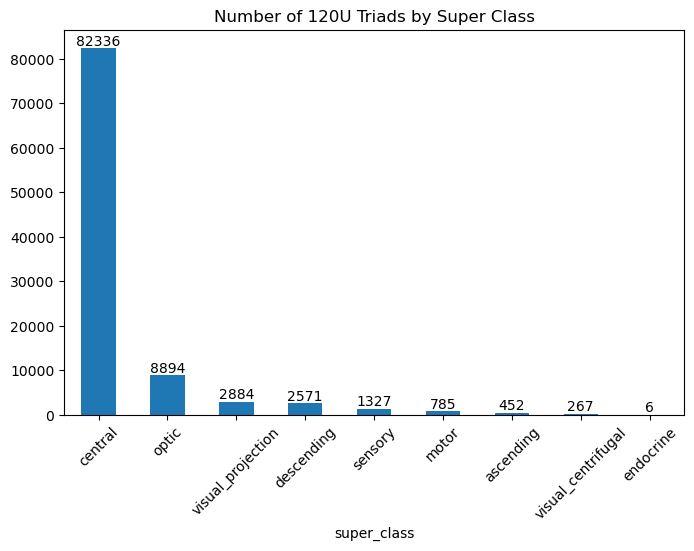

In [154]:
# Analyze the data, make a bar plot for each super_class and count up the rows 
fig, ax = plt.subplots(figsize=(8,5))
df_found_desc["super_class"].value_counts().plot(kind='bar')

# Rotate the x-axis labels to 45 degrees
plt.xticks(rotation=45)

# Add in labels for each bar
for i, v in enumerate(df_found_desc["super_class"].value_counts()):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Add in a title
plt.title("Number of 120U Triads by Super Class")

In [155]:
# 
df_found_desc_unique = df_found_desc.drop_duplicates(subset=["nid"])
df_found_desc_unique

,reciprocal1,reciprocal2,nid,root_id,super_class
0,720575940627737365,720575940628914436,720575940617537570,720575940617537570,central
1,720575940627737365,720575940628914436,720575940648650884,720575940648650884,central
2,720575940627737365,720575940628914436,720575940606056905,720575940606056905,central
3,720575940627737365,720575940628914436,720575940618308825,720575940618308825,central
4,720575940627737365,720575940628914436,720575940622920074,720575940622920074,central
...,...,...,...,...,...
99516,720575940619966680,720575940614095843,720575940629796218,720575940629796218,optic
99517,720575940628582888,720575940632232418,720575940620608647,720575940620608647,optic
99518,720575940631261637,720575940619531072,720575940615324822,720575940615324822,optic
99519,720575940640153216,720575940626933706,720575940627209994,720575940627209994,optic


Text(0, 0.5, 'Triad Count')

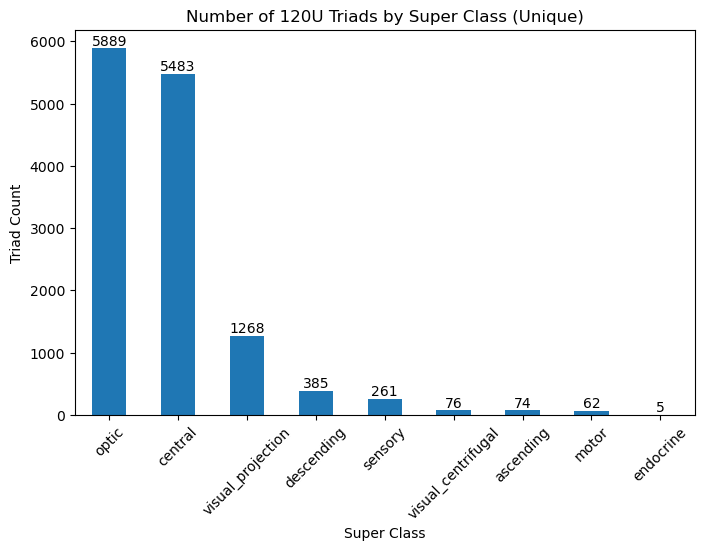

In [170]:
# Filter dataframe so there are only unique nid values
fig, ax = plt.subplots(figsize=(8,5))
df_found_desc_unique["super_class"].value_counts().plot(kind='bar')

# Rotate the x-axis labels to 45 degrees
plt.xticks(rotation=45)

# Add in labels for each bar
for i, v in enumerate(df_found_desc_unique["super_class"].value_counts()):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Add in a title
plt.title("Number of 120U Triads by Super Class (Unique)")
plt.xlabel("Super Class")
plt.ylabel("Triad Count")

In [157]:
# Create a portionality column to see the percentage of each super_class, 
# This means counting the number of rows for each super_class and dividing by the total number of rows (normalize)
# The map function here maps each super_class to the proportionality value found in the value_counts
df_found_desc_unique["proportionality"] = df_found_desc_unique["super_class"].map(df_found_desc_unique["super_class"].value_counts(normalize=True))
df_found_desc_unique

,reciprocal1,reciprocal2,nid,root_id,super_class,proportionality
0,720575940627737365,720575940628914436,720575940617537570,720575940617537570,central,0.406058
1,720575940627737365,720575940628914436,720575940648650884,720575940648650884,central,0.406058
2,720575940627737365,720575940628914436,720575940606056905,720575940606056905,central,0.406058
3,720575940627737365,720575940628914436,720575940618308825,720575940618308825,central,0.406058
4,720575940627737365,720575940628914436,720575940622920074,720575940622920074,central,0.406058
...,...,...,...,...,...,...
99516,720575940619966680,720575940614095843,720575940629796218,720575940629796218,optic,0.436125
99517,720575940628582888,720575940632232418,720575940620608647,720575940620608647,optic,0.436125
99518,720575940631261637,720575940619531072,720575940615324822,720575940615324822,optic,0.436125
99519,720575940640153216,720575940626933706,720575940627209994,720575940627209994,optic,0.436125


In [158]:
# Isolate each super class and their portionality
df_pro_class = df_found_desc_unique[['super_class', 'proportionality']].drop_duplicates().dropna()
df_pro_class = df_pro_class.sort_values(by="proportionality", ascending=False).reset_index(drop=True)
df_pro_class

,super_class,proportionality
0,optic,0.436125
1,central,0.406058
2,visual_projection,0.093905
3,descending,0.028512
4,sensory,0.019329
5,visual_centrifugal,0.005628
6,ascending,0.005480
7,motor,0.004592
8,endocrine,0.000370


Text(0.5, 1.0, 'Proportionality of Super Classes Occurance')

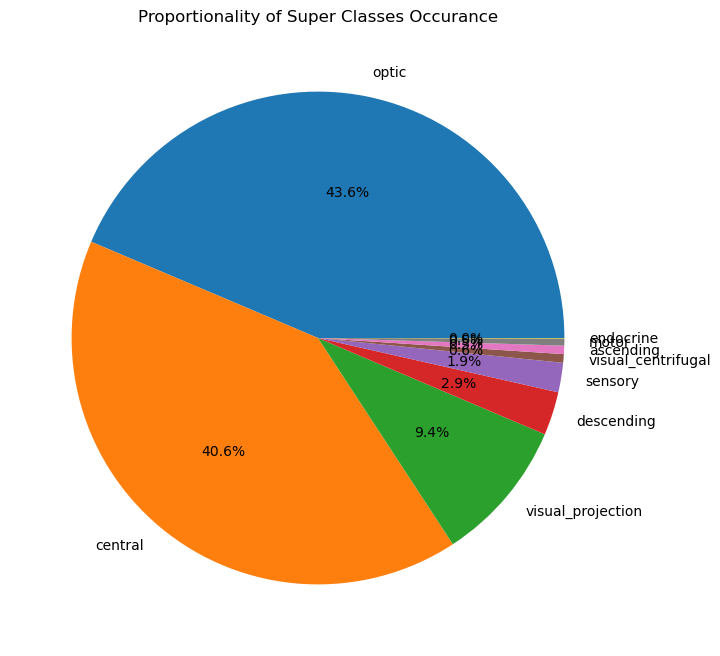

In [159]:
# Create a pie plot for the proportionality column for each super class
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(df_pro_class["proportionality"], labels=df_pro_class["super_class"], autopct='%1.1f%%')

# Add a title to the plot
plt.title("Proportionality of Super Classes Occurance")




In [160]:
# Isolate 
descending_only = (df_found_desc[df_found_desc['super_class']=='descending']).reset_index(drop=True)
descending_only_small = descending_only.head(2)


In [161]:
descending_only_small

,reciprocal1,reciprocal2,nid,root_id,super_class
0,720575940619895125,720575940614065676,720575940628352850,720575940628352850,descending
1,720575940619895125,720575940616169578,720575940628352850,720575940628352850,descending


This next part will be 
1. a for loop that iterates through the triads of df_found 
2. syn_table_f is filtered for just the edges in that triad (all possible combos)
3. those rows (plus all columns) will be attached to df_triad_final
4. the triad index will be the triad index from the df_found, for example for each connection that makes up the triad in the first row of df_found (index=0), their indexes will be 0 in the df_traid_final dataframe, so around 4 of them should be 0 since they are all 120U

In [171]:
# Create a dataframe wtih multiIndex and populate traid column to 286724 rows all with 0
# a for loop that iterates through the rows of df_found
def triad_info(df):
    df_new = pd.DataFrame(columns=["pre_root_id", "post_root_id", "neuropil", "syn_count", 'nt_type', 'triad'])
    for index, row in df.iterrows():
        # For large set runs:
        if (index+1)%10000 == 0:
            print("10000 done!")
        
        # Find the pre_root_id and post_root_id of the edge1, edge2, and edge3
        id_1 = int(row["reciprocal1"])
        id_2 = int(row["reciprocal2"])
        id_3 = int(row["nid"])
        
        # Find connections in the syn_table_f that match the combinations of id_1, id_2, and id_3
        # use combinations to find all possible combinations of the 3 ids
        for comb in permutations([id_1, id_2, id_3], 2):

            # Find the rows that match the combinations
            rows = syn_table[(syn_table["pre_root_id"] == comb[0]) & (syn_table["post_root_id"] == comb[1])]
            
            # If there are rows that match the combinations
            if not rows.empty:
                # Add the triad value to the rows
                rows["triad"] = index+1
                # Add the rows to the df_new dataframe
                df_new = pd.concat([df_new, rows]).reset_index(drop=True)

    return df_new

In [172]:
df_small_desc = triad_info(descending_only_small)
df_small_desc

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,triad
0,720575940619895125,720575940614065676,AL_L,33,ACH,1
1,720575940619895125,720575940628352850,AL_L,80,ACH,1
2,720575940614065676,720575940619895125,AL_L,43,ACH,1
3,720575940614065676,720575940628352850,AL_L,22,ACH,1
4,720575940619895125,720575940616169578,AL_L,42,ACH,2
5,720575940619895125,720575940628352850,AL_L,80,ACH,2
6,720575940616169578,720575940619895125,AL_L,52,GABA,2
7,720575940616169578,720575940628352850,AL_L,25,GABA,2


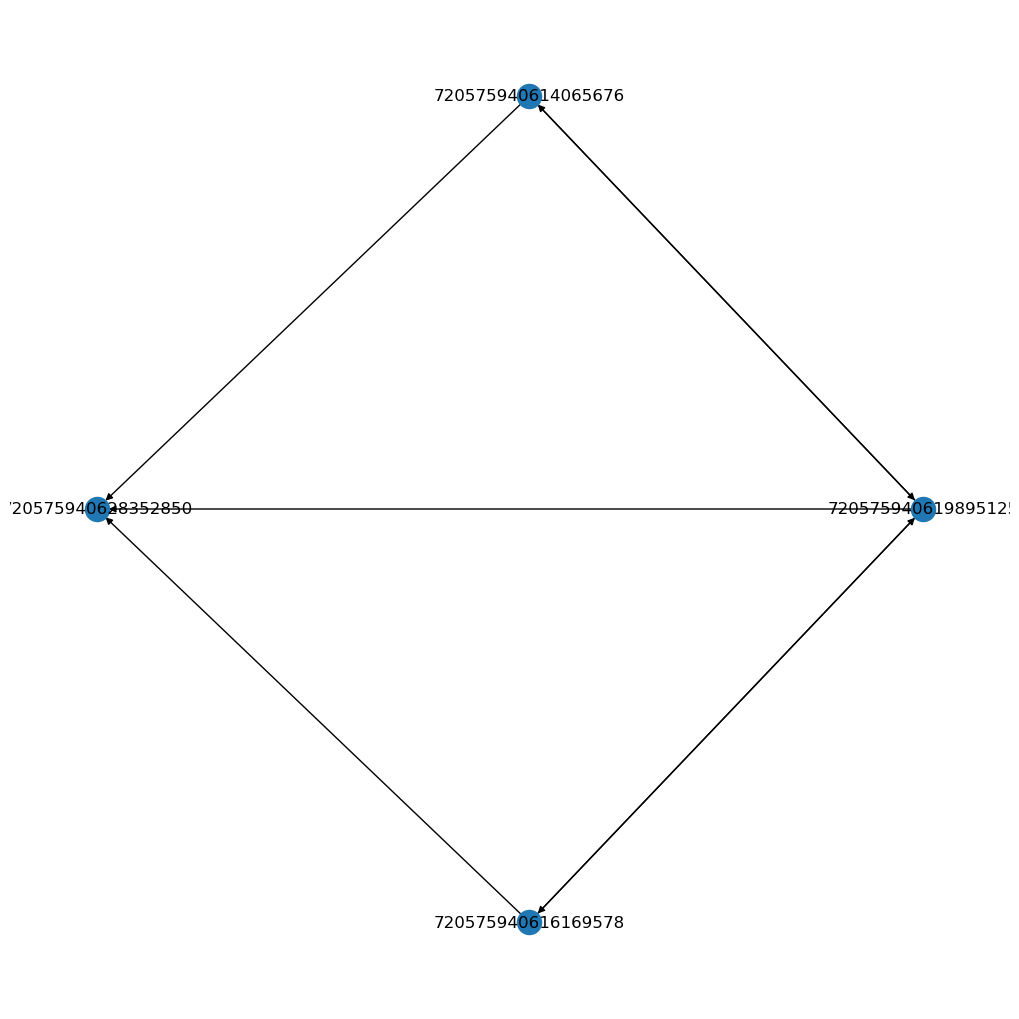

In [174]:
# Make a network graph of the descending super class
G = nx.DiGraph()
plt.figure(figsize=(10, 10))
# Add the edges to the graph from dataframe
G.add_edges_from(df_small_desc[["pre_root_id", "post_root_id"]].values)
# Plot the graph
nx.draw_kamada_kawai(G, with_labels=True)


In [90]:
# Testing
# isolate (39572,85031) and (18605, 85031) in the pre_nid and post_nid columns
df_test_nid = df_small_desc[((df_small_desc["pre_nid"] == 39572) & (df_small_desc["post_nid"] == 85031)| (df_small_desc["pre_nid"] == 18605) & (df_small_desc["post_nid"] == 85031)| (df_small_desc["pre_nid"] == 39572) & (df_small_desc["post_nid"] == 18605)| (df_small_desc["pre_nid"] == 18605) & (df_small_desc["post_nid"] == 39572) )]

In [91]:
# See if df_test_nid rows are in df_small_desc
df_test_nid = df_test_nid.reset_index(drop=True)
df_test_nid

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,pre_nid,post_nid
0,720575940619895125,720575940614065676,AL_L,33,ACH,39572,18605
1,720575940619895125,720575940628352850,AL_L,80,ACH,39572,85031
2,720575940614065676,720575940619895125,AL_L,43,ACH,18605,39572
3,720575940614065676,720575940628352850,AL_L,22,ACH,18605,85031


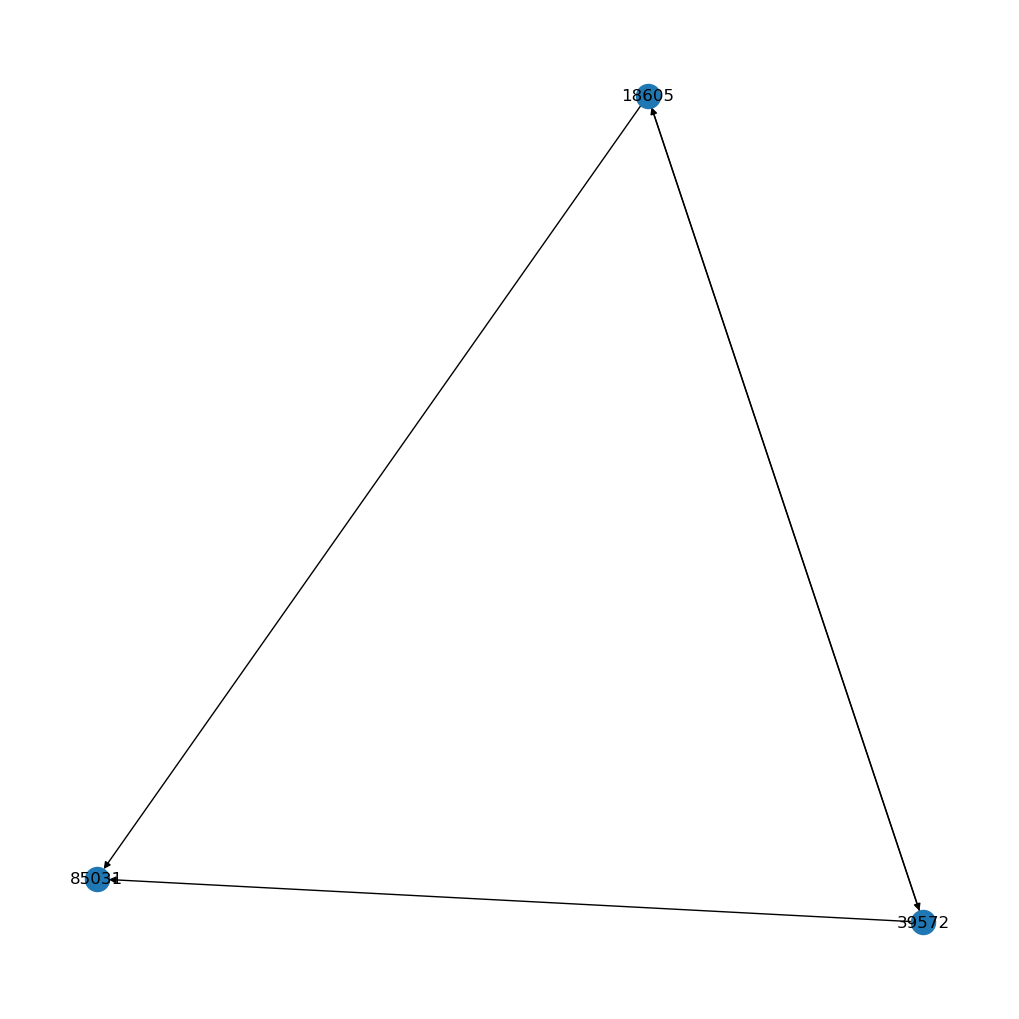

In [92]:
# Make a network graph of the descending super class
G = nx.DiGraph()
plt.figure(figsize=(10, 10))
# Add the edges to the graph from dataframe
G.add_edges_from(df_test_nid[["pre_nid", "post_nid"]].values)
# Plot the graph
nx.draw(G, with_labels=True)

### Running the info finder on the Whole dataframe

In [175]:
descending_only

,reciprocal1,reciprocal2,nid,root_id,super_class
0,720575940619895125,720575940614065676,720575940628352850,720575940628352850,descending
1,720575940619895125,720575940616169578,720575940628352850,720575940628352850,descending
2,720575940619895125,720575940631899223,720575940628352850,720575940628352850,descending
3,720575940619895125,720575940611671506,720575940628352850,720575940628352850,descending
4,720575940619895125,720575940623605943,720575940628352850,720575940628352850,descending
...,...,...,...,...,...
2566,720575940631342073,720575940639196760,720575940618574749,720575940618574749,descending
2567,720575940631342073,720575940639196760,720575940625870640,720575940625870640,descending
2568,720575940611720690,720575940620691672,720575940628352850,720575940628352850,descending
2569,720575940611720690,720575940620691672,720575940620153765,720575940620153765,descending


In [176]:
# Info finder on descending_only df
# Turn off warning for SettingWithCopyWarning
pd.options.mode.chained_assignment = None
df_descending_all_info = triad_info(descending_only)
df_descending_all_info

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,triad
0,720575940619895125,720575940614065676,AL_L,33,ACH,1
1,720575940619895125,720575940628352850,AL_L,80,ACH,1
2,720575940614065676,720575940619895125,AL_L,43,ACH,1
3,720575940614065676,720575940628352850,AL_L,22,ACH,1
4,720575940619895125,720575940616169578,AL_L,42,ACH,2
...,...,...,...,...,...,...
12860,720575940620691672,720575940620153765,SPS_L,44,ACH,2570
12861,720575940633220679,720575940615675732,SPS_R,32,GABA,2571
12862,720575940633220679,720575940605041330,SPS_R,24,GABA,2571
12863,720575940615675732,720575940633220679,SPS_R,33,GABA,2571


In [177]:
# I want to find the triad with the highest syn_count, this means for each triad value, find the max syn_count for the rows that have that triad value
df_descending_all_info = df_descending_all_info.dropna()

# Group by triad and sum the syn_count values
triad_max_finder = df_descending_all_info.groupby("triad")["syn_count"].sum().reset_index()
# sorts the values by syn_count in descending order
triad_max_finder = triad_max_finder.sort_values(by="syn_count", ascending=False).reset_index(drop=True)
triad_max_finder

,triad,syn_count
0,703,1046
1,702,1034
2,706,1023
3,2253,1004
4,707,985
...,...,...
2566,1272,67
2567,658,67
2568,740,66
2569,2267,66


In [181]:
# Isolating triad 702
triad_702 = df_descending_all_info[df_descending_all_info["triad"] == 2253]
triad_702

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,triad
11381,720575940628802069,720575940626495746,GNG,100,ACH,2253
11382,720575940628802069,720575940618574749,GNG,179,ACH,2253
11383,720575940626495746,720575940628802069,GNG,375,GABA,2253
11384,720575940626495746,720575940618574749,GNG,350,GABA,2253


### Finding E/I Pairs....
I think this can be done by appending the info (nt or other) onto pre_root_id and then again on post_root_id, and then isolating the ones that are E/I!

In [182]:
df_found_desc

,reciprocal1,reciprocal2,nid,root_id,super_class
0,720575940627737365,720575940628914436,720575940617537570,720575940617537570,central
1,720575940627737365,720575940628914436,720575940648650884,720575940648650884,central
2,720575940627737365,720575940628914436,720575940606056905,720575940606056905,central
3,720575940627737365,720575940628914436,720575940618308825,720575940618308825,central
4,720575940627737365,720575940628914436,720575940622920074,720575940622920074,central
...,...,...,...,...,...
99517,720575940628582888,720575940632232418,720575940620608647,720575940620608647,optic
99518,720575940631261637,720575940619531072,720575940615324822,720575940615324822,optic
99519,720575940640153216,720575940626933706,720575940627209994,720575940627209994,optic
99520,720575940628285973,720575940624948553,720575940624654570,720575940624654570,optic


In [183]:
# Import neurons info
df_neurons = pd.read_csv('/Users/rweberla/Downloads/neurons.csv')
df_neurons = df_neurons[["root_id", "nt_type"]]
df_neurons

,root_id,nt_type
0,720575940596125868,ACH
1,720575940597856265,ACH
2,720575940597944841,ACH
3,720575940598267657,GABA
4,720575940599333574,ACH
...,...,...
139250,720575940661335681,GABA
139251,720575940661336193,ACH
139252,720575940661337217,ACH
139253,720575940661338497,NaN


In [198]:
# Combine nid from df_neurons onto df_found_desc reciprocal1

df_filtered1 = df_found_desc.merge(df_neurons, left_on='reciprocal1', right_on='root_id', how="left",)
df_filtered2 = df_filtered1.merge(df_neurons, left_on='reciprocal2', right_on='root_id', how="left", suffixes=('_pre','_post'))
df_filtered2

,reciprocal1,reciprocal2,nid,root_id_x,super_class,root_id_y,nt_type_pre,root_id,nt_type_post
0,720575940627737365,720575940628914436,720575940617537570,720575940617537570,central,720575940627737365,ACH,720575940628914436,NaN
1,720575940627737365,720575940628914436,720575940648650884,720575940648650884,central,720575940627737365,ACH,720575940628914436,NaN
2,720575940627737365,720575940628914436,720575940606056905,720575940606056905,central,720575940627737365,ACH,720575940628914436,NaN
3,720575940627737365,720575940628914436,720575940618308825,720575940618308825,central,720575940627737365,ACH,720575940628914436,NaN
4,720575940627737365,720575940628914436,720575940622920074,720575940622920074,central,720575940627737365,ACH,720575940628914436,NaN
...,...,...,...,...,...,...,...,...,...
99517,720575940628582888,720575940632232418,720575940620608647,720575940620608647,optic,720575940628582888,NaN,720575940632232418,ACH
99518,720575940631261637,720575940619531072,720575940615324822,720575940615324822,optic,720575940631261637,ACH,720575940619531072,GLUT
99519,720575940640153216,720575940626933706,720575940627209994,720575940627209994,optic,720575940640153216,GABA,720575940626933706,ACH
99520,720575940628285973,720575940624948553,720575940624654570,720575940624654570,optic,720575940628285973,ACH,720575940624948553,GLUT


In [202]:
# Find reciprocal1 and reciprocal2 edges that are ach, gaba
df_e_i_pairs = df_filtered2[((df_filtered2["nt_type_pre"] == "ACH") & (df_filtered2["nt_type_post"] == "GABA")|(df_filtered2["nt_type_pre"] == "GABA") & (df_filtered2["nt_type_post"] == "ACH") |(df_filtered2["nt_type_pre"] == "ACH") & (df_filtered2["nt_type_post"] == "GLUT")|(df_filtered2["nt_type_pre"] == "GLUT") & (df_filtered2["nt_type_post"] == "ACH"))]
df_e_i_pairs

,reciprocal1,reciprocal2,nid,root_id_x,super_class,root_id_y,nt_type_pre,root_id,nt_type_post
1583,720575940619895125,720575940631448680,720575940621398254,720575940621398254,central,720575940619895125,ACH,720575940631448680,GLUT
1584,720575940619895125,720575940631448680,720575940640830453,720575940640830453,central,720575940619895125,ACH,720575940631448680,GLUT
1585,720575940619895125,720575940631448680,720575940627927573,720575940627927573,central,720575940619895125,ACH,720575940631448680,GLUT
1586,720575940619895125,720575940631448680,720575940623605943,720575940623605943,central,720575940619895125,ACH,720575940631448680,GLUT
1587,720575940619895125,720575940621398254,720575940631619921,720575940631619921,central,720575940619895125,ACH,720575940621398254,GABA
...,...,...,...,...,...,...,...,...,...
99510,720575940635694015,720575940627398940,720575940643846560,720575940643846560,optic,720575940635694015,ACH,720575940627398940,GLUT
99515,720575940627241747,720575940638344282,720575940628714005,720575940628714005,optic,720575940627241747,GLUT,720575940638344282,ACH
99518,720575940631261637,720575940619531072,720575940615324822,720575940615324822,optic,720575940631261637,ACH,720575940619531072,GLUT
99519,720575940640153216,720575940626933706,720575940627209994,720575940627209994,optic,720575940640153216,GABA,720575940626933706,ACH


In [203]:
df_e_i_pairs = df_e_i_pairs[['reciprocal1', 'reciprocal2', 'nid', 'nt_type_pre', 'nt_type_post', 'super_class']]
df_e_i_pairs

,reciprocal1,reciprocal2,nid,nt_type_pre,nt_type_post,super_class
1583,720575940619895125,720575940631448680,720575940621398254,ACH,GLUT,central
1584,720575940619895125,720575940631448680,720575940640830453,ACH,GLUT,central
1585,720575940619895125,720575940631448680,720575940627927573,ACH,GLUT,central
1586,720575940619895125,720575940631448680,720575940623605943,ACH,GLUT,central
1587,720575940619895125,720575940621398254,720575940631619921,ACH,GABA,central
...,...,...,...,...,...,...
99510,720575940635694015,720575940627398940,720575940643846560,ACH,GLUT,optic
99515,720575940627241747,720575940638344282,720575940628714005,GLUT,ACH,optic
99518,720575940631261637,720575940619531072,720575940615324822,ACH,GLUT,optic
99519,720575940640153216,720575940626933706,720575940627209994,GABA,ACH,optic


In [209]:
# Isolate the descending super class
df_e_i_pairs_desc = df_e_i_pairs[df_e_i_pairs['super_class']=='descending'].reset_index(drop=True)
df_e_i_pairs_desc

,reciprocal1,reciprocal2,nid,nt_type_pre,nt_type_post,super_class
0,720575940604569824,720575940624471373,720575940610505006,GABA,ACH,descending
1,720575940604569824,720575940612685162,720575940631282194,GABA,ACH,descending
2,720575940604569824,720575940612267518,720575940631282194,GABA,ACH,descending
3,720575940638668659,720575940627491914,720575940627946261,GABA,ACH,descending
4,720575940637902938,720575940629393207,720575940621392086,ACH,GABA,descending
...,...,...,...,...,...,...
1554,720575940631342073,720575940639196760,720575940629805950,GABA,ACH,descending
1555,720575940631342073,720575940639196760,720575940618574749,GABA,ACH,descending
1556,720575940631342073,720575940639196760,720575940625870640,GABA,ACH,descending
1557,720575940611720690,720575940620691672,720575940628352850,GABA,ACH,descending


In [210]:
df_pairs_info = triad_info(df_e_i_pairs_desc)
df_pairs_info

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,triad
0,720575940604569824,720575940624471373,AVLP_R,144,GABA,1
1,720575940604569824,720575940610505006,AVLP_R,72,GABA,1
2,720575940624471373,720575940604569824,AVLP_R,15,ACH,1
3,720575940624471373,720575940610505006,AVLP_R,23,ACH,1
4,720575940604569824,720575940612685162,AVLP_R,15,GABA,2
...,...,...,...,...,...,...
7895,720575940620691672,720575940628352850,SPS_L,16,ACH,1558
7896,720575940611720690,720575940620691672,SPS_L,64,GABA,1559
7897,720575940611720690,720575940620153765,SPS_L,19,GABA,1559
7898,720575940620691672,720575940611720690,SPS_L,21,ACH,1559


In [211]:
df_pairs_info = df_pairs_info.dropna()

# Group by triad and sum the syn_count values
triad_max_finder = df_pairs_info.groupby("triad")["syn_count"].sum().reset_index()
# sorts the values by syn_count in descending order
triad_max_finder = triad_max_finder.sort_values(by="syn_count", ascending=False).reset_index(drop=True)
triad_max_finder

,triad,syn_count
0,1348,1004
1,1352,898
2,359,897
3,1351,881
4,300,849
...,...,...
1554,1458,70
1555,608,70
1556,1478,68
1557,397,66


In [212]:
# Isolate triad 93689
df_pairs_info[df_pairs_info["triad"] == 1348]

,pre_root_id,post_root_id,neuropil,syn_count,nt_type,triad
6890,720575940628802069,720575940626495746,GNG,100,ACH,1348
6891,720575940628802069,720575940618574749,GNG,179,ACH,1348
6892,720575940626495746,720575940628802069,GNG,375,GABA,1348
6893,720575940626495746,720575940618574749,GNG,350,GABA,1348
